In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import re
from pathlib import Path

import mplhep as hep
hep.style.use(hep.style.ATLAS)

from utils import read_perf_analyzer_output, plot_backend_compare
from utils import plot_backend, check_inputpath, check_outputpath

# 1 instance on 1 GPU

In [14]:
custom_backend_results_path = "../results/1insts_1gpus/perf_analyzer_1insts_1gpus_sync.csv"
pd_custom = read_perf_analyzer_output(custom_backend_results_path)
var_name = "Inferences/Second"
custom_backend_results = {
    "Concurrency": pd_custom["Concurrency"],
    var_name: pd_custom[var_name]
}

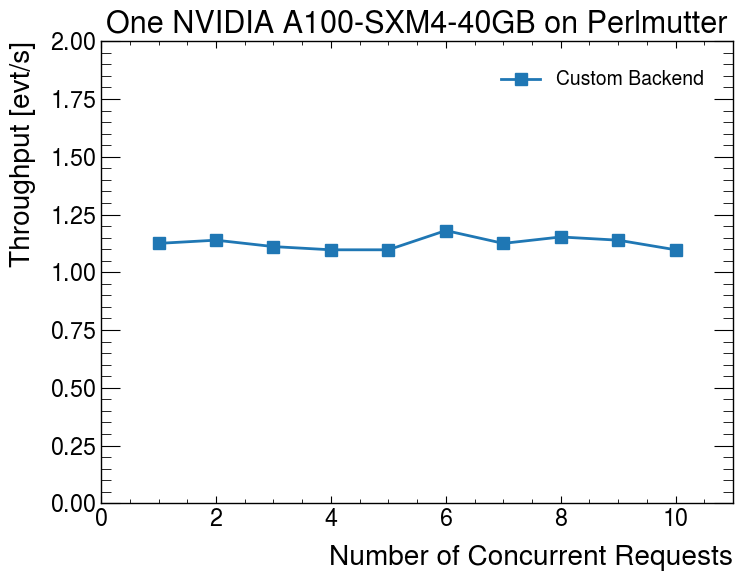

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(custom_backend_results["Concurrency"], custom_backend_results[var_name], label="Custom Backend", marker="s")

ax.set_xlim(0, 11)
ax.set_xlabel("Number of Concurrent Requests")
ax.set_ylabel("Throughput [evt/s]")
ax.set_title("One NVIDIA A100-SXM4-40GB on Perlmutter", fontsize=22)
ax.set_ylim(0, 2.0)
ax.legend()
# fig.savefig("throughput_vs_concurrency_1inst_1gpu.pdf", dpi=600, bbox_inches="tight")
# fig.savefig("throughput_vs_concurrency_1inst_1gpu.png", dpi=600, bbox_inches="tight")


# multiple instances on 1 GPU

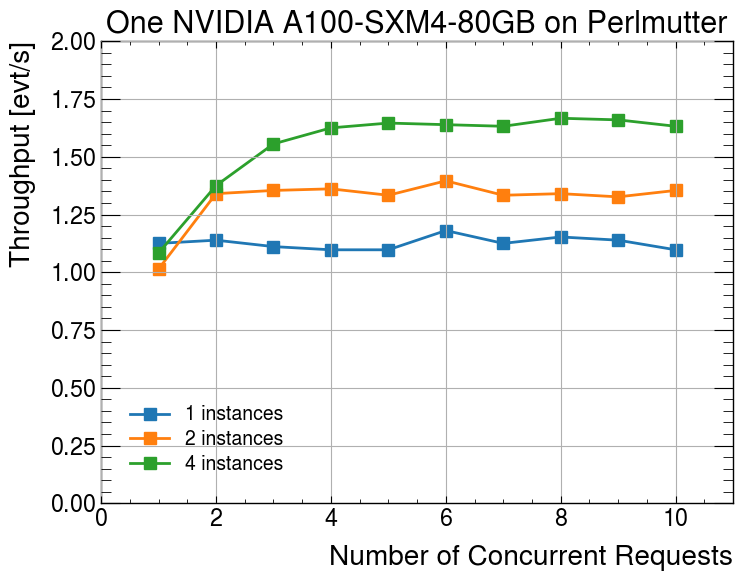

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(1, 5):
    if i == 3:
        continue
    custom_backend_results_path = f"../results/{i}insts_1gpus/perf_analyzer_{i}insts_1gpus_sync.csv"
    pd_custom = read_perf_analyzer_output(custom_backend_results_path)
    var_name = "Inferences/Second"
    custom_backend_results = {
        "Concurrency": pd_custom["Concurrency"],
        var_name: pd_custom[var_name]
    }

    ax.plot(custom_backend_results["Concurrency"], custom_backend_results[var_name], label=f"{i} instances", marker="s")

ax.set_xlim(0, 11)
ax.set_xlabel("Number of Concurrent Requests")
ax.set_ylabel("Throughput [evt/s]")
ax.set_title("One NVIDIA A100-SXM4-80GB on Perlmutter", fontsize=22)
ax.set_ylim(0, 2.0)
ax.legend()
ax.grid()


# Max Throughput vs instances 

In [36]:
custom_backend_results_path = "../results/"
custom_backend_results_path = check_inputpath(custom_backend_results_path)

pattern = r'(\d+)insts_1gpus$'
sync_mode = "sync"
n_instance_threshold = 6

def extract_number_GPUutilization(s):
    match = re.search(r'(\d+\.\d+)', s)
    if match:
        return float(match.group(1))
    return None

def exatract_perf_vs_instances(backend_results_path):
    backend_results = {
        "n_instances": [],
        "Throughput_mean": [],
        "Throughput_std": [], 
        "GPU Utilization": [],
    }

    different_ins_results_path = sorted([item for item in backend_results_path.iterdir() if item.is_dir()])
    for instance_result_path in different_ins_results_path:
        
        match = re.search(pattern, instance_result_path.stem)
        if match:
            n_instance = int(match.group(1)) 
        else:
            # raise ValueError("No instance number found in the path.") 
            print(f"No instance number found in the path: {instance_result_path}")
            continue

        backend_results["n_instances"].append(n_instance)
        csv_file_pattern = f"*_{sync_mode}.csv"
        csv_file = sorted(instance_result_path.glob(csv_file_pattern))[0]

        pd_csv = read_perf_analyzer_output(csv_file)

        pd_saturated = pd_csv.query(f"Concurrency >= {n_instance_threshold}")
        backend_results["Throughput_mean"].append(pd_saturated[var_name].mean())
        backend_results["Throughput_std"].append(pd_saturated[var_name].std())
        
        # gpu_util = pd_saturated['Avg GPU Utilization'].apply(extract_number_GPUutilization).mean()
        gpu_util = pd_saturated['Avg GPU Utilization'].mean()[-1]
        backend_results["GPU Utilization"].append(gpu_util)

    return backend_results


In [37]:
custom_backend_results = exatract_perf_vs_instances(custom_backend_results_path)

No instance number found in the path: ../results/1insts_2gpus
No instance number found in the path: ../results/1insts_4gpus
No instance number found in the path: ../results/1insts_4gpus_backup
No instance number found in the path: ../results/2insts_1gpus_odd
No instance number found in the path: ../results/2insts_1gpus_toogood
No instance number found in the path: ../results/2insts_2gpus


(0.8, 4.2)

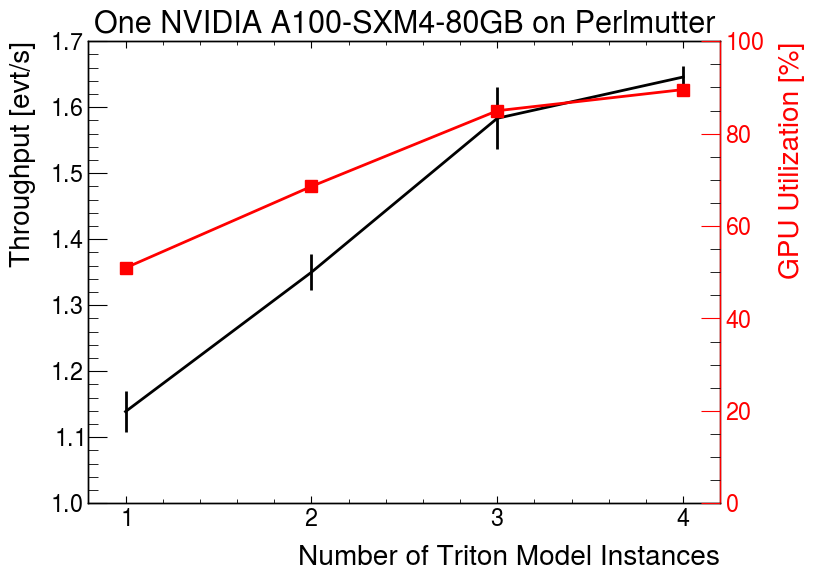

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xticks(custom_backend_results["n_instances"])
ax.errorbar(custom_backend_results["n_instances"], 
            custom_backend_results["Throughput_mean"], 
            yerr=custom_backend_results["Throughput_std"], 
            label="Custom Backend", color="black")

# twin object for two different y-axis on the sample plot
ax2_color = "red"
ax2=ax.twinx()
ax2.plot(custom_backend_results["n_instances"], 
         np.array(custom_backend_results["GPU Utilization"]) * 100, 
         label="GPU Utilization", color="red", marker="s")

ax2.tick_params(axis='y', colors=ax2_color)
ax2.spines['right'].set_color(ax2_color)

ax.set_xlabel("Number of Triton Model Instances")
ax.set_ylabel("Throughput [evt/s]")
ax.set_title("One NVIDIA A100-SXM4-80GB on Perlmutter", fontsize=22)

ax2.set_ylim(0,100)
ax2.set_ylabel("GPU Utilization [%]", color=ax2_color)

ax.set_xlim(0.8, 4.2)

# fig.savefig("avg_throughput_vs_instances_1gpu.pdf", dpi=600, bbox_inches="tight")
# fig.savefig("avg_throughput_vs_instances_1gpu.png", dpi=600, bbox_inches="tight")